# Image Super-resolution using GANs
### A PG-Independent Study

Ankit Pant

2018201035

M.Tech. Computer Science \& Engineering

International Institute of Information Technology, Hyderabad

ankit.pant@students.iiit.ac.in

Supervised by: Dr. Pawan Kumar

### Connecting to Google Drive
Google Drive contains the datasets that are used in training the model. Once the model is trained, it is saved in Google Drive as well.




In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Creating noisy images from original images
The following code, reads the original high-resolution images and converts them to low resolution images to be used the training dataset.

In [ ]:
# import statements
from fastai.vision import *
from fastai.datasets import *
from fastai.callbacks import *
from fastai.vision.gan import *
from PIL import Image

# the size of the low-resolution images
size = 128

# path to the original images
path_orig = Path('/content/drive/My Drive/SR_dataset/temp_train')
src = ImageList.from_folder(path_orig).split_by_rand_pct(valid_pct=0.2)

# Information about the training dataset
print(src)

# create the low resolution versions
path_noise = Path('/content/drive/My Drive/SR_dataset/Noisy_Images')
path_train = Path('/content/drive/My Drive/SR_dataset/Original_Images')
i = 0
for fl in src.items:
  pth_str = str(fl)
  flname = pth_str.split('/')[-1]
  img = PIL.Image.open(fl)
  orig_img  = PIL.Image.open(fl)
  resz_opt = resize_to(img,size,use_min=True)
  img = img.resize(resz_opt).convert('RGB')
  #choosing image quality; 10 => worst
  img.save(path_noise/flname, quality=10)
  # saving the low resolution images created
  orig_img.save(path_train/flname)
  if(i%100==0):
    print("Image: ",flname," saved!")
  i+=1






ItemLists;

Train: ImageList (1600 items)
Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024)
Path: /content/drive/My Drive/SR_dataset/temp_train;

Valid: ImageList (400 items)
Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024)
Path: /content/drive/My Drive/SR_dataset/temp_train;

Test: None
Image:  01000.png  saved!
Image:  01125.png  saved!
Image:  01253.png  saved!
Image:  01375.png  saved!
Image:  01502.png  saved!
Image:  01629.png  saved!
Image:  01750.png  saved!
Image:  01867.png  saved!
Image:  01992.png  saved!
Image:  03126.png  saved!
Image:  03249.png  saved!
Image:  03373.png  saved!
Image:  03491.png  saved!
Image:  03629.png  saved!
Image:  03754.png  saved!
Image:  03879.png  saved!


### Loading training images and pre-training generator model
The saved low resolution images are loaded and the generator model is pre-trained by using the original images as ground truth

ItemLists;

Train: ImageImageList (1280 items)
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /content/drive/My Drive/SR_dataset/Noisy_Images;

Valid: ImageImageList (320 items)
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /content/drive/My Drive/SR_dataset/Noisy_Images;

Test: None


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-03
Min loss divided by 10: 4.79E-03


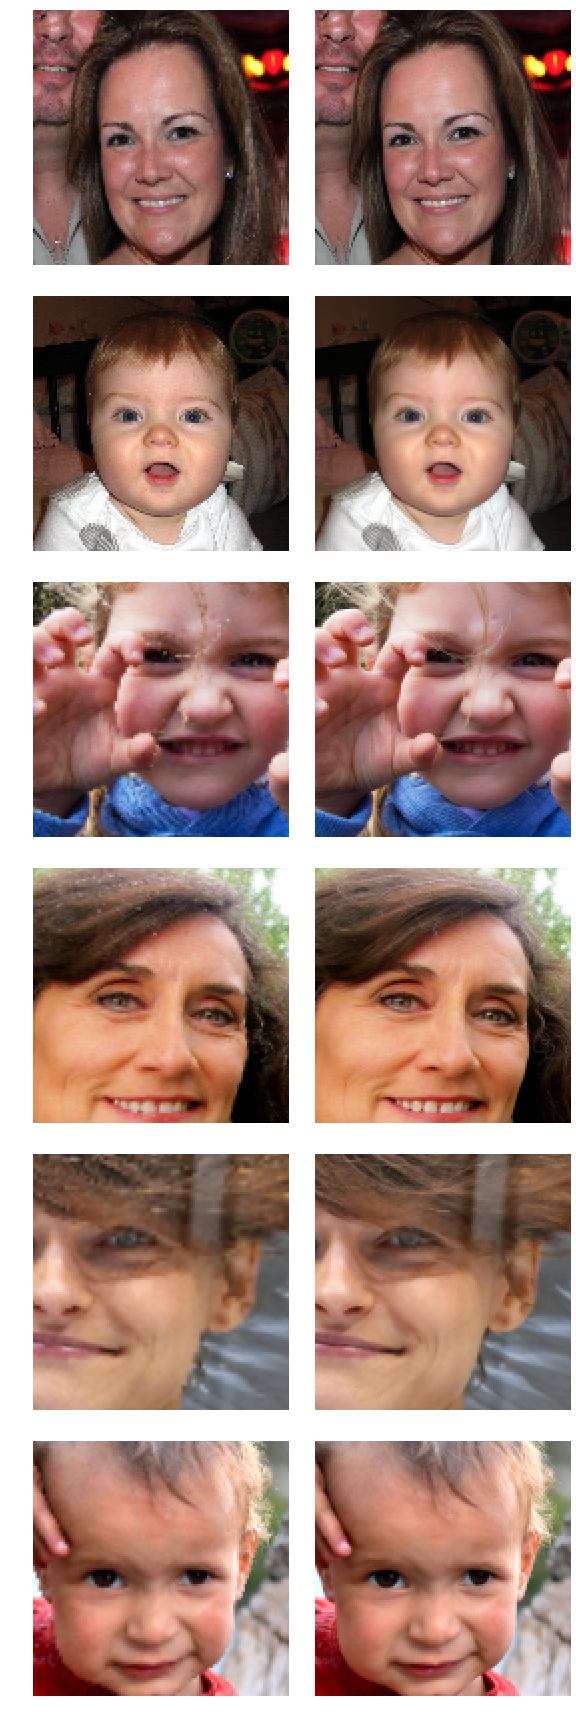

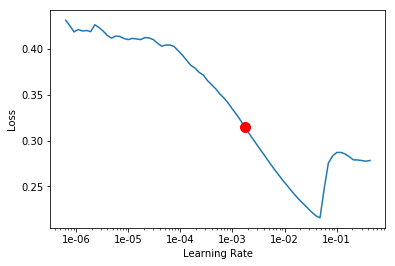

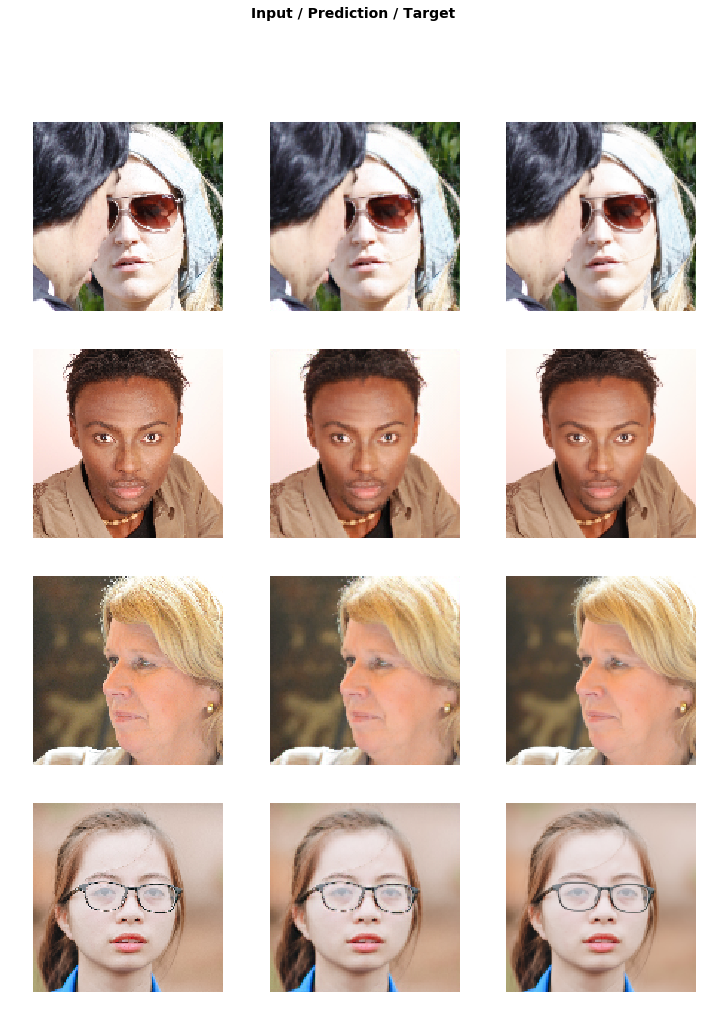

In [ ]:
from fastai.vision import *
from fastai.datasets import *
from fastai.callbacks import *
from fastai.vision.gan import *
from PIL import Image
#removing warning about some alignment
import warnings
warnings.filterwarnings("ignore")

# size of low resolution images
size = [128,128]
# size of the batch (batch contains that many number of images which are trained at one time)
batch_size = 8

# path to the stored original and low-resolution images
path_orig = Path('/content/drive/My Drive/SR_dataset/Original_Images/')
path_noise = Path('/content/drive/My Drive/SR_dataset/Noisy_Images/')

# reading the images and creating dataset
src = ImageImageList.from_folder(path_noise).split_by_rand_pct(valid_pct=0.2, seed=31)


# Information about the training dataset
print(src)
# print(src2)

# creating dataset
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_orig/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

# defining the loss function for the generator model
loss_fun = MSELossFlat()

# created training data
data_gen = get_data(batch_size,size)
# display the training data
data_gen.show_batch(6)

#creating generator with unet architecture resnet34 base architecture (pre-trained)
arch = models.resnet34
def create_gan_learner():
    return unet_learner(data_gen, arch, blur=True, norm_type=NormType.Weight, self_attention=True, loss_func=loss_fun)

gen_learner = create_gan_learner()
# training with created dataset
gen_learner.fit_one_cycle(2, 1e-5)
# to find the optimal learning rate
gen_learner.lr_find()
gen_learner.recorder.plot(suggestion=True)
# allow the pre-trained paramenters to be modified
gen_learner.unfreeze()
gen_learner.fit_one_cycle(5, slice(1e-4,1e-3))'
# show results after the training
gen_learner.show_results(rows=4)

# Saving the pre-trained generator model
gen_learner.save('/content/drive/My Drive/SR_dataset/saved_gen_model')

#gen_learner.load('/content/drive/My Drive/SR_dataset/saved_gen_model')

path_gen_images = Path('/content/drive/My Drive/SR_dataset/Generated_Images/')

# saving the generated images
path_gen_images.mkdir(exist_ok=True)

i = 0
names = data_gen.fix_dl.dataset.items
for bat in data_gen.fix_dl:
  preds = gen_learner.pred_batch(batch=bat, reconstruct=True)
  for o in preds:
      o.save(path_gen_images/names[i].name)
      i += 1


### Comparing the nosiy and generated images

The following code compares the low resolution images to the images generated by the generator model in the previous step.

In [ ]:
from fastai.vision import *
from skimage import measure 
import cv2
import numpy as npy
import glob
import pandas as pds
import os

path_orig = Path('/content/drive/My Drive/SR_dataset/Original_Images/')
path_noise = Path('/content/drive/My Drive/SR_dataset/Noisy_Images/')
path_gen = Path('/content/drive/My Drive/SR_dataset/Generated_Images/')

# Mean Squared Error measure
def MSE(image1, image2):
  error = npy.sum((image1.astype("float") - image2.astype("float")) ** 2)
  error /= float(image1.shape[0] * image2.shape[1])
  return error

# Peak Signal to Noise Ratio measure
def PSNR(image1, image2):
  mserr = MSE(image1,image2)
  if mserr == 0:
    return 100
  max_pixel_val = 255.0
  return 20 * math.log10(max_pixel_val / math.sqrt(mserr))
 
# MS-SSIM measure
def MS_SSIM(image1, image2):
  error = measure.compare_ssim(image1,image2,multichannel=True)
  return error

# L1 measure
def L1(image1, image2):
  error = npy.sum(npy.absolute(image1.astype("float") - image2.astype("float")))
  return error

files_orig = []
files_noisy = []
files_gen = []

# load the various images for comparison
for filename in os.listdir(path_orig):
  img = cv2.imread(os.path.join(path_orig,filename))
  if img is not None:
    img = cv2.resize(img, (128, 128))
    files_orig.append(img)

for filename in os.listdir(path_noise):
  img = cv2.imread(os.path.join(path_noise,filename))
  if img is not None:
    files_noisy.append(img)

for filename in os.listdir(path_gen):
  img = cv2.imread(os.path.join(path_gen,filename))
  if img is not None:
    files_gen.append(img)
    
print(len(files_orig))
print(len(files_noisy))
print(len(files_gen))


noisy_mse_error = []
noisy_psnr_error = []
noisy_ssim_error = []
noisy_l1_error = []

noisy_avg_mse = 0
noisy_avg_psnr = 0
noisy_avg_ssim = 0
noisy_avg_l1 = 0


for oimage, nimage in zip(files_orig, files_noisy):
  orig_image = oimage
  noisy_image = nimage
  mse = MSE(orig_image,noisy_image)
  noisy_mse_error.append(mse)
  psnr = PSNR(orig_image,noisy_image)
  noisy_psnr_error.append(psnr)
  ssim = MS_SSIM(orig_image,noisy_image)
  noisy_ssim_error.append(ssim)
  l1 = L1(orig_image,noisy_image)
  noisy_l1_error.append(l1)

# calculate average error values for low-resolution images
noisy_avg_mse = sum(noisy_mse_error)/len(noisy_mse_error)
noisy_avg_psnr = sum(noisy_psnr_error)/len(noisy_psnr_error)
noisy_avg_ssim = sum(noisy_ssim_error)/len(noisy_ssim_error)
noisy_avg_l1 = sum(noisy_l1_error)/len(noisy_l1_error)

gen_mse_error = []
gen_psnr_error = []
gen_ssim_error = []
gen_l1_error = []

gen_avg_mse = 0
gen_avg_psnr = 0
gen_avg_ssim = 0
gen_avg_l1 = 0


for oimage, gimage in zip(files_orig, files_gen):
  orig_image = oimage
  gen_image = gimage
  mse = MSE(orig_image,gen_image)
  gen_mse_error.append(mse)
  psnr = PSNR(orig_image,gen_image)
  gen_psnr_error.append(psnr)
  ssim = MS_SSIM(orig_image,gen_image)
  gen_ssim_error.append(ssim)
  l1 = L1(orig_image,gen_image)
  gen_l1_error.append(l1)

# calculate average error values for generated images
gen_avg_mse = sum(gen_mse_error)/len(gen_mse_error)
gen_avg_psnr = sum(gen_psnr_error)/len(gen_psnr_error)
gen_avg_ssim = sum(gen_ssim_error)/len(gen_ssim_error)
gen_avg_l1 = sum(gen_l1_error)/len(gen_l1_error)


print("\nTable containing various error measures when compared to original images")

df = pds.DataFrame({'Image type':['Noisy Image', 'Generated Images'],
                    'average error SSIM':[noisy_avg_ssim, gen_avg_ssim],
                   'average error MSE':[noisy_avg_mse, gen_avg_mse],
                   'average error PSNR':[noisy_avg_psnr, gen_avg_psnr],
                   'average error L1':[noisy_avg_l1, gen_avg_l1]},
                  columns = ['Image type','average error SSIM','average error MSE','average error PSNR', 'average error L1'])
df




1600
1600
1280

Table containing various error measures when compared to original images


Image type  average error SSIM  ...  average error PSNR  average error L1
0       Noisy Image            0.127138  ...            4.295813      3.603803e+06
1  Generated Images            0.135904  ...            4.304846      3.611744e+06

[2 rows x 5 columns]

### Pre-training the discriminator model

The discriminator model is now pre-trained to differentiate between the original images and the generated images.

ImageDataBunch;

Train: LabelList (2304 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
Original_Images,Original_Images,Original_Images,Original_Images,Original_Images
Path: /content/drive/My Drive/SR_dataset;

Valid: LabelList (576 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
Original_Images,Generated_Images,Original_Images,Original_Images,Original_Images
Path: /content/drive/My Drive/SR_dataset;

Test: None


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E+00
Min loss divided by 10: 1.58E-05


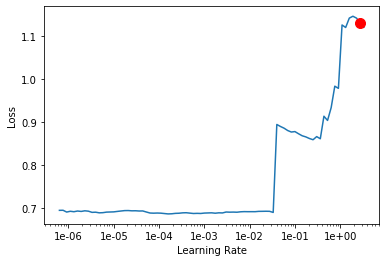

In [ ]:
from fastai.vision import *
from fastai.datasets import *
from fastai.callbacks import *
from fastai.vision.gan import *
from PIL import Image
#removing warning about some alignment
import warnings
warnings.filterwarnings("ignore")


name_gen = 'Generated_Images'
name_orig = 'Original_Images'
name_mod = 'Noisy_Images'
# image size of generated image
size = [128,128]
# images will be processed in batches whose size equal to batch_size
batch_size = 10

root_path = '/content/drive/My Drive/SR_dataset/'

# create dataset
def get_disc_data(classes,bs, size):
    src = ImageList.from_folder(root_path, include=classes).split_by_rand_pct(0.2)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

# get data
disc_data = get_disc_data([name_gen, name_orig],batch_size,size)
print(disc_data)

# disc_data.show_batch(rows=2, ds_type=DatasetType.Train, imgsize=3)
# disc_data.show_batch(rows=2, ds_type=DatasetType.Valid, imgsize=3)

# define the loss function for the discriminiator
disc_loss = AdaptiveLoss(nn.BCEWithLogitsLoss())

# create basic discriminator
def create_disc_learner(disc_data,met):  
  return Learner(disc_data, gan_critic(), metrics=met, loss_func=disc_loss)

disc_learner = create_disc_learner(disc_data,accuracy_thresh_expand)

# training the discrimnator
disc_learner.fit_one_cycle(2, 1e-3)
disc_learner.lr_find()
disc_learner.recorder.plot(suggestion=True)
disc_learner.unfreeze()
disc_learner.fit_one_cycle(6, 1e-6)

# saving the discriminator model
disc_learner.save('/content/drive/My Drive/SR_dataset/saved_disc_model')

### Training the GAN

Both the pre-trained generator and pre-trained discriminator models are now combined and trained in tandem.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


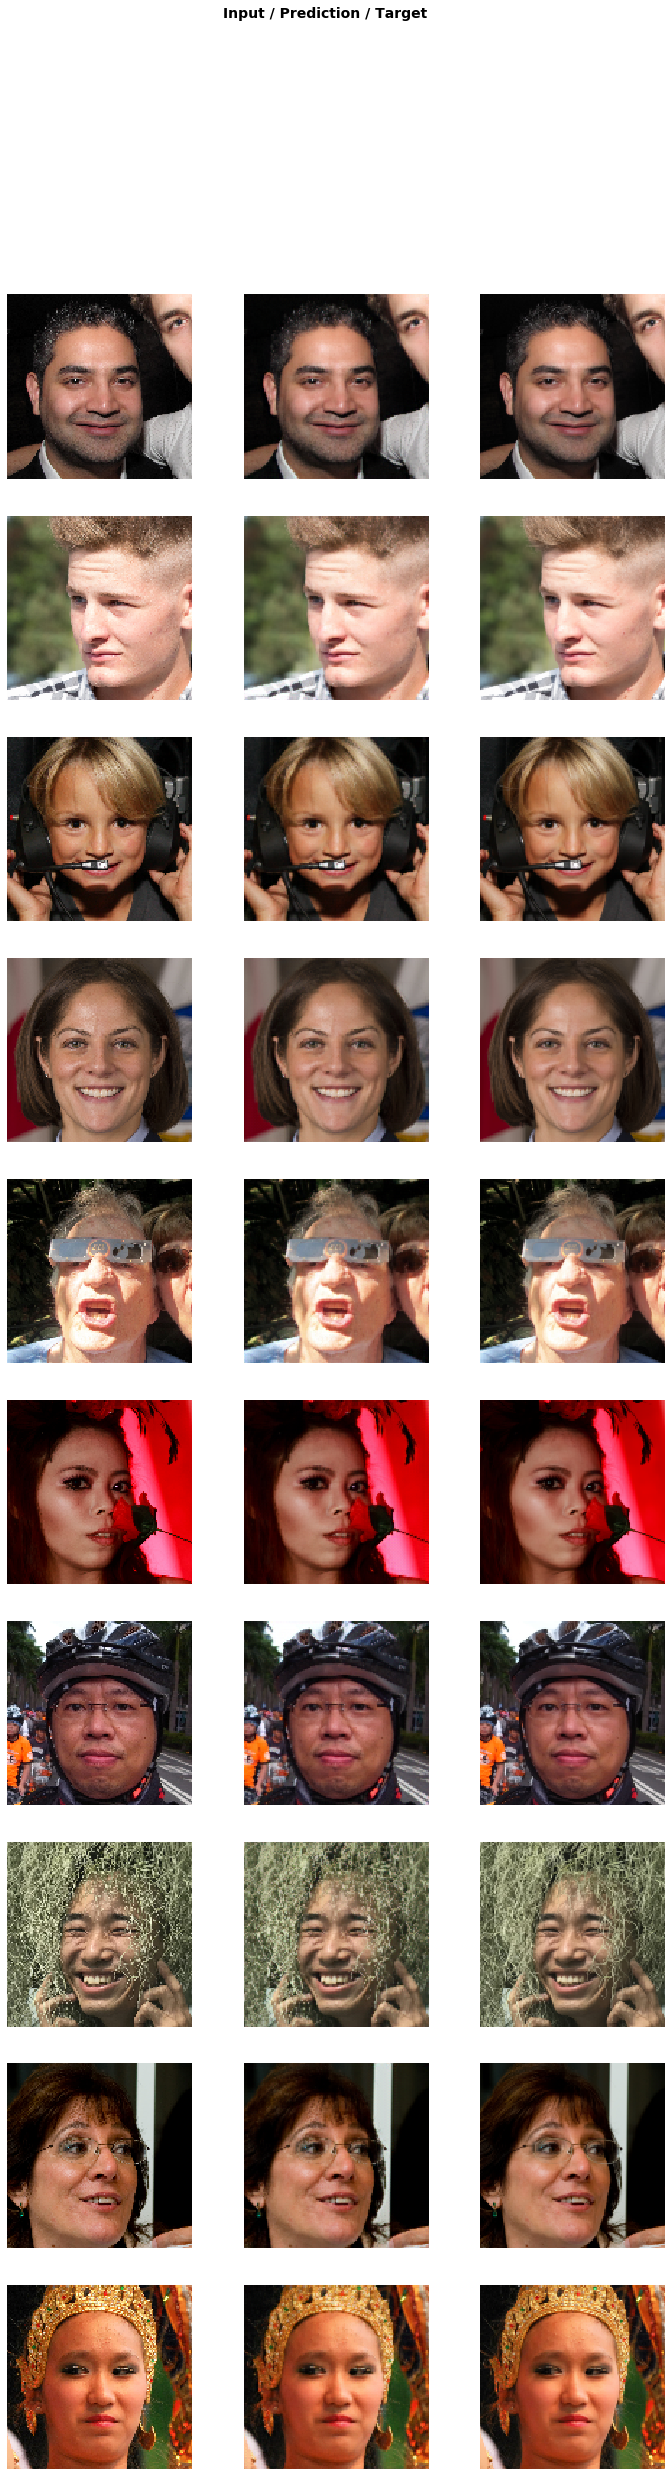

In [ ]:
from fastai.vision import *
from fastai.datasets import *
from fastai.callbacks import *
from fastai.vision.gan import *
from PIL import Image
#removing warning about some alignment
import warnings
warnings.filterwarnings("ignore")

name_gen = 'Generated_Images'
name_orig = 'Original_Images'
name_mod = 'Noisy_Images'
size = [128,128]
batch_size = 10

path_orig = Path('/content/drive/My Drive/SR_dataset/Original_Images/')
path_noise = Path('/content/drive/My Drive/SR_dataset/Noisy_Images/')

src = ImageImageList.from_folder(path_noise).split_by_rand_pct(valid_pct=0.2, seed=31)

# create dataset
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_orig/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

loss_fun = MSELossFlat()

data_gen = get_data(batch_size,size)

arch = models.resnet34
def create_gan_learner():
    return unet_learner(data_gen, arch, blur=True, norm_type=NormType.Weight, self_attention=True, loss_func=loss_fun)

root_path = '/content/drive/My Drive/SR_dataset/'

def get_disc_data(classes,bs, size):
    src = ImageList.from_folder(root_path, include=classes).split_by_rand_pct(0.2)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data



data_disc = get_disc_data([name_mod, name_orig],bs=batch_size,size=size)

disc_loss = AdaptiveLoss(nn.BCEWithLogitsLoss())

def create_disc_learner(disc_data,met):  
  return Learner(disc_data, gan_critic(), metrics=met, loss_func=disc_loss)


disc_learner = create_disc_learner(data_disc,met=None).load('/content/drive/My Drive/SR_dataset/saved_disc_model')
gen_learner = create_gan_learner().load('/content/drive/My Drive/SR_dataset/saved_gen_model')

#switcher is used to switch between the generator and the discriminator

switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.6)
# create GAN model

gan_learner = GANLearner.from_learners(gen_learner, disc_learner, weights_gen=(1.,50.), show_img=False, switcher=switcher,opt_func=partial(optim.Adam, betas=(0.,0.99)))
gan_learner.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

# train the model
gan_learner.fit_one_cycle(2, 1e-3)
gan_learner.lr_find()
disc_learner.unfreeze()
gan_learner.fit(20,1e-6)

# save the model
gan_learner.save('/content/drive/My Drive/SR_dataset/saved_gan_model')

#show results
gan_learner.show_results(rows=20)

#save the model to be used with the web application
gen_learner.export('/content/drive/My Drive/SR_dataset/gan_model.pkl')


### Saving generated images after running through GAN
The following code now save the images that are obtained as predictions from the GAN model

In [ ]:
from fastai.vision import *
from fastai.datasets import *
from fastai.callbacks import *
from fastai.vision.gan import *
from PIL import Image
#removing warning about some alignment
import warnings
warnings.filterwarnings("ignore")

path_orig = Path('/content/drive/My Drive/SR_dataset/Original_Images/')
path_gen = Path('/content/drive/My Drive/SR_dataset/Generated_Images/')

src = ImageImageList.from_folder(path_gen).split_none()

size = [128,128]
batch_size = 20

# creating dataset
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_orig/x.name)
           .transform(get_transforms(max_zoom=1.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

data_gen = get_data(batch_size,size)

path_gan_images = Path('/content/drive/My Drive/SR_dataset/GAN_Images')
learner_path = Path('/content/drive/My Drive/SR_dataset/saved_gan_model')
gan_learner = load_learner('/content/drive/My Drive/SR_dataset/','gan_model.pkl')
names = data_gen.fix_dl.dataset.items

i = 0
for bat in data_gen.fix_dl:
  preds = gan_learner.pred_batch(batch=bat, reconstruct=True)
  for o in preds:
      o.save(path_gan_images/names[i].name)
      i += 1

### Upsampling the Image

The following code is used to upsample the generated images to the size of 512x512

ImageDataBunch;

Train: LabelList (240 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: /content/drive/My Drive/SR_dataset/Low_Res_Images;

Valid: LabelList (60 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: /content/drive/My Drive/SR_dataset/Low_Res_Images;

Test: None


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:07<00:00, 76.4MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 7.59E-08


AttributeError: ignored

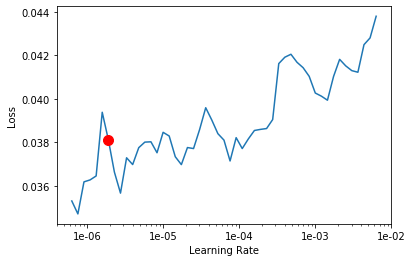

In [ ]:
from fastai.vision import *
from fastai.datasets import *
from fastai.callbacks import *
from fastai.vision.gan import *
from PIL import Image
#removing warning about some alignment
import warnings
warnings.filterwarnings("ignore")

scale = 4
size = [512,512]
batch_size = 1


path_orig = Path('/content/drive/My Drive/SR_dataset/Original_Images/')
path_lowres = Path('/content/drive/My Drive/SR_dataset/Low_Res_Images/')

src = ImageImageList.from_folder(path_lowres).split_by_rand_pct(0.2)


# creating dataset
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_orig/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

img_data = get_data(batch_size,size)

print(img_data)

# using MSE as loss function
loss_fun = MSELossFlat()
#using VGG16 as base architecture of the unet-model
arch = models.vgg16_bn
def create_upsampler(data, met):
    return unet_learner(data, arch, blur=True, norm_type=NormType.Weight, self_attention=True, loss_func=loss_fun)

#creating the model and training
upsampler = create_upsampler(img_data, accuracy_thresh)
upsampler.fit_one_cycle(1, 1e-3)
upsampler.lr_find()
upsampler.recorder.plot(suggestion=True)
upsampler.unfreeze()
upsampler.fit_one_cycle(10, 1e-6)

#saving the model
upsampler.save('/content/drive/My Drive/SR_dataset/saved_upsampler_model')

# attempting to save the model for web application but due to limitations of python cannot do that directly. 
# the error in the output is due to the next statement when python refuses to save the model
# upsampler.export('/content/drive/My Drive/SR_dataset/upsampler_model.pkl')
upsampler.show_results(rows=5)

### Saving the up-sampler model

The following code is used to store the up-sampler model as a pickle file to be used later

In [ ]:
import dill
from fastai.vision import *
from fastai.datasets import *
from fastai.callbacks import *
from fastai.vision.gan import *
from PIL import Image
#removing warning about some alignment
import warnings
warnings.filterwarnings("ignore")

scale = 4
size = [512,512]
batch_size = 1


path_orig = Path('/content/drive/My Drive/SR_dataset/Original_Images/')
path_lowres = Path('/content/drive/My Drive/SR_dataset/Low_Res_Images/')
path_model = Path('/content/drive/My Drive/SR_dataset/upsampler.pkl')

src = ImageImageList.from_folder(path_lowres).split_by_rand_pct(0.2)


# creating dataset
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_orig/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

img_data = get_data(batch_size,size)

loss_fun = MSELossFlat()
arch = models.vgg16_bn
def create_upsampler(data, met):
    return unet_learner(data, arch, blur=True, norm_type=NormType.Weight, self_attention=True, loss_func=loss_fun)

upsampler = create_upsampler(img_data, accuracy_thresh).load('/content/drive/My Drive/SR_dataset/saved_upsampler_model')

#printing the loaded model that was saved in the previous cell
print(upsampler)

# using dill to export as pickle file as python's pickle module is unable to do so
with open(path_model, 'wb') as fl:
    dill.dump(upsampler,fl)


Learner(data=ImageDataBunch;

Train: LabelList (240 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: /content/drive/My Drive/SR_dataset/Low_Res_Images;

Valid: LabelList (60 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: /content/drive/My Drive/SR_dataset/Low_Res_Images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kerne

### Saving Enhanced Images

The images that have been upsampled are now saved

In [ ]:
import dill
from fastai.vision import *
from fastai.datasets import *
from fastai.callbacks import *
from fastai.vision.gan import *
from PIL import Image
#removing warning about some alignment
import warnings
warnings.filterwarnings("ignore")

path_orig = Path('/content/drive/My Drive/SR_dataset/Original_Images/')
path_gen = Path('/content/drive/My Drive/SR_dataset/Low_Res_Images/')

src = ImageImageList.from_folder(path_gen).split_none()
  
batch_size = 1
size = [512,512]

# creating dataset
def get_data(bs):
    data = (src.label_from_func(lambda x: path_orig/x.name)
           .transform(get_transforms(max_zoom=1.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

data_gen = get_data(batch_size)

path_enhance_images = Path('/content/drive/My Drive/SR_dataset/Enhanced_Images')
path_model = Path('/content/drive/My Drive/SR_dataset/upsampler.pkl')
with open(path_model, 'rb') as fl:
    upsampler = dill.load(fl)

names = data_gen.fix_dl.dataset.items

i = 0
j = 0
for bat in data_gen.fix_dl:
  j+=1
  preds = upsampler.pred_batch(batch=bat, reconstruct=True)
  for o in preds:
      o.save(path_enhance_images/names[i].name)
      i += 1
  print("Batch ",j," completed!")
 

Batch  1  completed!
Batch  2  completed!
Batch  3  completed!
Batch  4  completed!
Batch  5  completed!
Batch  6  completed!
Batch  7  completed!
Batch  8  completed!
Batch  9  completed!
Batch  10  completed!
Batch  11  completed!
Batch  12  completed!
Batch  13  completed!
Batch  14  completed!
Batch  15  completed!
Batch  16  completed!
Batch  17  completed!
Batch  18  completed!
Batch  19  completed!
Batch  20  completed!
Batch  21  completed!
Batch  22  completed!
Batch  23  completed!
Batch  24  completed!
Batch  25  completed!
Batch  26  completed!
Batch  27  completed!
Batch  28  completed!
Batch  29  completed!
Batch  30  completed!
Batch  31  completed!
Batch  32  completed!
Batch  33  completed!
Batch  34  completed!
Batch  35  completed!
Batch  36  completed!
Batch  37  completed!
Batch  38  completed!
Batch  39  completed!
Batch  40  completed!
Batch  41  completed!
Batch  42  completed!
Batch  43  completed!
Batch  44  completed!
Batch  45  completed!
Batch  46  complete

### Comparing noisy and enhanced images

The enhanced images and low resolution images are now compared to the original images

In [4]:
from fastai.vision import *
from skimage import measure 
import cv2
import numpy as npy
import glob
import pandas as pds
import os

path_orig = Path('/content/drive/My Drive/SR_dataset/Original_Images/')
path_noise = Path('/content/drive/My Drive/SR_dataset/Noisy_Images/')
path_gen = Path('/content/drive/My Drive/SR_dataset/Enhanced_Images/')

def MSE(image1, image2):
  error = npy.sum((image1.astype("float") - image2.astype("float")) ** 2)
  error /= float(image1.shape[0] * image2.shape[1])
  return error

def PSNR(image1, image2):
  mserr = MSE(image1,image2)
  if mserr == 0:
    return 100
  max_pixel_val = 255.0
  return 20 * math.log10(max_pixel_val / math.sqrt(mserr))
 
def MS_SSIM(image1, image2):
  error = measure.compare_ssim(image1,image2,multichannel=True)
  return error

def L1(image1, image2):
  error = npy.sum(npy.absolute(image1.astype("float") - image2.astype("float")))
  return error

files_orig = []
files_noisy = []
files_gen = []

for filename in os.listdir(path_orig):
  img = cv2.imread(os.path.join(path_orig,filename))
  if img is not None:
    img = cv2.resize(img, (512, 512))
    files_orig.append(img)

for filename in os.listdir(path_noise):
  img = cv2.imread(os.path.join(path_noise,filename))
  if img is not None:
    img = cv2.resize(img, (512, 512))
    files_noisy.append(img)

for filename in os.listdir(path_gen):
  img = cv2.imread(os.path.join(path_gen,filename))
  if img is not None:
    files_gen.append(img)
    
print(len(files_orig))
print(len(files_noisy))
print(len(files_gen))


noisy_mse_error = []
noisy_psnr_error = []
noisy_ssim_error = []
noisy_l1_error = []

noisy_avg_mse = 0
noisy_avg_psnr = 0
noisy_avg_ssim = 0
noisy_avg_l1 = 0


for oimage, nimage in zip(files_orig, files_noisy):
  orig_image = oimage
  noisy_image = nimage
  mse = MSE(orig_image,noisy_image)
  noisy_mse_error.append(mse)
  psnr = PSNR(orig_image,noisy_image)
  noisy_psnr_error.append(psnr)
  ssim = MS_SSIM(orig_image,noisy_image)
  noisy_ssim_error.append(ssim)
  l1 = L1(orig_image,noisy_image)
  noisy_l1_error.append(l1)

noisy_avg_mse = sum(noisy_mse_error)/len(noisy_mse_error)
noisy_avg_psnr = sum(noisy_psnr_error)/len(noisy_psnr_error)
noisy_avg_ssim = sum(noisy_ssim_error)/len(noisy_ssim_error)
noisy_avg_l1 = sum(noisy_l1_error)/len(noisy_l1_error)

gen_mse_error = []
gen_psnr_error = []
gen_ssim_error = []
gen_l1_error = []

gen_avg_mse = 0
gen_avg_psnr = 0
gen_avg_ssim = 0
gen_avg_l1 = 0


for oimage, gimage in zip(files_orig, files_gen):
  orig_image = oimage
  gen_image = gimage
  mse = MSE(orig_image,gen_image)
  gen_mse_error.append(mse)
  psnr = PSNR(orig_image,gen_image)
  gen_psnr_error.append(psnr)
  ssim = MS_SSIM(orig_image,gen_image)
  gen_ssim_error.append(ssim)
  l1 = L1(orig_image,gen_image)
  gen_l1_error.append(l1)

gen_avg_mse = sum(gen_mse_error)/len(gen_mse_error)
gen_avg_psnr = sum(gen_psnr_error)/len(gen_psnr_error)
gen_avg_ssim = sum(gen_ssim_error)/len(gen_ssim_error)
gen_avg_l1 = sum(gen_l1_error)/len(gen_l1_error)


print("\nTable containing various error measures when compared to original images")

df = pds.DataFrame({'Image type':['Noisy Image', 'Generated Images'],
                    'average error SSIM':[noisy_avg_ssim, gen_avg_ssim],
                   'average error MSE':[noisy_avg_mse, gen_avg_mse],
                   'average error PSNR':[noisy_avg_psnr, gen_avg_psnr],
                   'average error L1':[noisy_avg_l1, gen_avg_l1]},
                  columns = ['Image type','average error SSIM','average error MSE','average error PSNR', 'average error L1'])
df




1600
1600
300

Table containing various error measures when compared to original images


Image type  average error SSIM  ...  average error PSNR  average error L1
0       Noisy Image            0.308175  ...            4.370232      5.720727e+07
1  Generated Images            0.340402  ...            4.456091      5.675491e+07

[2 rows x 5 columns]

### Evaluating model on test-set

The entire model (GAN + upsampler) is now used to make predictions on the different test data

Enahanced Images: 


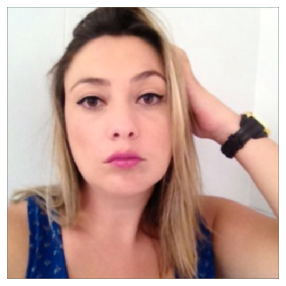

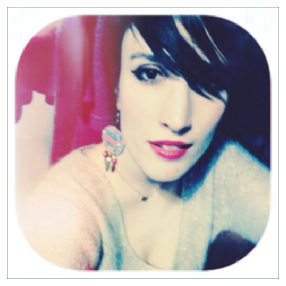

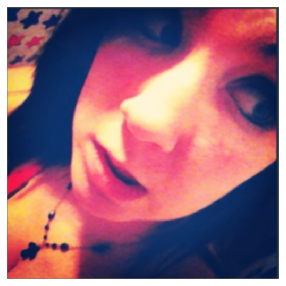

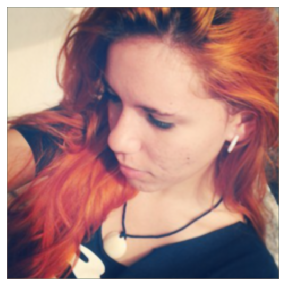

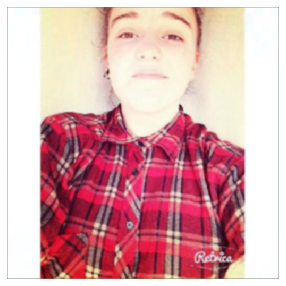

In [ ]:
import dill
from fastai.vision import *
from fastai.datasets import *
from fastai.callbacks import *
from fastai.vision.gan import *
from PIL import Image
#removing warning about some alignment
import warnings
warnings.filterwarnings("ignore")

path_test = Path('/content/drive/My Drive/SR_dataset/Test_Images/')


src = ImageImageList.from_folder(path_test).split_none()
  
batch_size = 1
size = [512,512]

# creating dataset
def get_data(bs):
    data = (src.label_from_func(lambda x: path_test/x.name)
           .transform(get_transforms(max_zoom=1.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

data_gen = get_data(batch_size)

# print("Original Images:")
# data_gen.show_batch(rows=5, figsize=(5,5))

# loading the GAN model
gan_learner = load_learner('/content/drive/My Drive/SR_dataset/','gan_model.pkl')

# loading the upsampler model
path_model = Path('/content/drive/My Drive/SR_dataset/upsampler.pkl')
with open(path_model, 'rb') as fl:
    upsampler = dill.load(fl)

names = data_gen.fix_dl.dataset.items

print("Enahanced Images: ")
i = 1
for bat in data_gen.fix_dl:
  preds =  gan_learner.pred_batch(batch=bat, reconstruct=True)
  up_preds = upsampler.predict(preds[0])
  # show some predictions made on images from the test dataset
  if(i%9==0):
    show_image(up_preds[0],figsize=(5,5))
  i+=1






### Alternative model for web-app

Using the alternate method to save the upsampler did not work with the web-application due to limited hardware on the local machine (where the web app is deployed). Hence an alternate up-sampling model is created that is then used by the web application.

ImageDataBunch;

Train: LabelList (240 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: /content/drive/My Drive/SR_dataset/Low_Res_Images;

Valid: LabelList (60 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: /content/drive/My Drive/SR_dataset/Low_Res_Images;

Test: None


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Failed to compute the gradients, there might not be enough points.


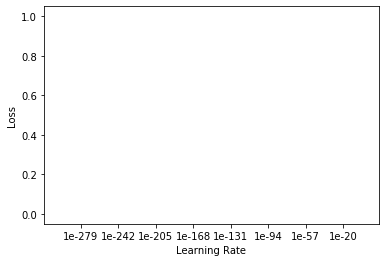

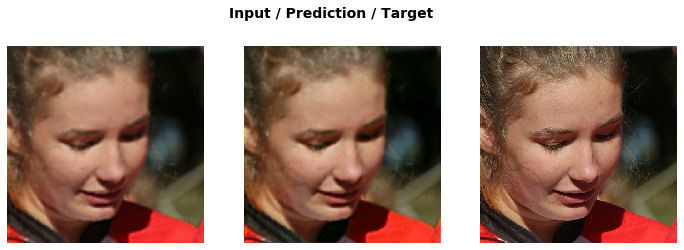

In [ ]:
from fastai.vision import *
from fastai.datasets import *
from fastai.callbacks import *
from fastai.vision.gan import *
from PIL import Image
#removing warning about some alignment
import warnings
warnings.filterwarnings("ignore")

scale = 1
size = [512,512]
batch_size = 1


path_orig = Path('/content/drive/My Drive/SR_dataset/Original_Images/')
path_lowres = Path('/content/drive/My Drive/SR_dataset/Low_Res_Images/')

src = ImageImageList.from_folder(path_lowres).split_by_rand_pct(0.2)


# creating dataset
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_orig/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

img_data = get_data(batch_size,size)

print(img_data)

def conv(ni, nf, kernel_size=3, actn=True):
  layers = [nn.Conv2d(ni, nf, kernel_size, padding=kernel_size//2)]
  if actn: 
    layers.append(nn.ReLU(True))
  return nn.Sequential(*layers)

# the code for the following classes has been largely derived from fast.ai

# creating a RenNet class
class ResModel(nn.Module):
    def __init__(self, layers, res_scale=1.0):
        super().__init__()
        self.res_scale = res_scale
        self.m = nn.Sequential(*layers)

    def forward(self, x):
        x = x + self.m(x) * self.res_scale
        return x

def res_block(nf):
    return ResModel(
        [conv(nf, nf), nn.BatchNorm2d(nf), conv(nf, nf), conv(nf, nf, actn=False)],
        0.1)

def upsample(ni, nf, sc):
  layers = []
  for i in range(int(math.log(sc,2))):
      layers += [conv(ni, nf*4), nn.PixelShuffle(2)]
  return nn.Sequential(*layers)

# Creating a Module for Super Resolution
class SRResnet(nn.Module):
    def __init__(self, nf, scale):
        super().__init__()
        features = [conv(3, 32)]
        for i in range(4): features.append(res_block(32))
        features += [conv(32,32), upsample(32, 32, scale),
                     nn.BatchNorm2d(32),
                     conv(32, 3, actn=False)]
        self.features = nn.Sequential(*features)
        
    def forward(self, x): return self.features(x)

modl = SRResnet(32,scale)
loss_fun = MSELossFlat()
#arch = models.vgg16_bn
def create_upsampler(data, met):
    # return unet_learner(data, arch, blur=True, norm_type=NormType.Weight, self_attention=True, loss_func=loss_fun)
  return Learner(data, modl, metrics=met, opt_func=optim.Adam, loss_func=loss_fun)

#training the upsampler
upsampler = create_upsampler(img_data, accuracy_thresh)
upsampler.fit_one_cycle(1, 1e-3)
upsampler.lr_find()
upsampler.recorder.plot(suggestion=True)
upsampler.unfreeze()
upsampler.fit_one_cycle(10, 1e-6)

# save the model 
upsampler.save('/content/drive/My Drive/SR_dataset/saved_upsampler2_model')
upsampler.export('/content/drive/My Drive/SR_dataset/upsampler_model_2.pkl')

# show result of the up sampling model
upsampler.show_results(rows=1)